<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Modules, Helpful Functions, & Styling</h1>

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd
import tensorflow_hub as th
import h5py,pylab as pl
import tensorflow as tf,keras as ks
from sklearn.model_selection import train_test_split
from IPython.display import display,HTML
import PIL.Image

Using TensorFlow backend.


In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d');
span {font-family:Roboto; color:black; text-shadow:3px 3px 3px #aaa;}  
div.output_area pre{font-family:Roboto; font-size:110%; color:#ff603b;}      
</style>

In [3]:
fpath='../input/image-examples-for-mixed-styles/'
fpath2='../input/flower-color-images/'
hpath='https://tfhub.dev/google/magenta/'+\
      'arbitrary-image-stylization-v1-256/1'
fw1='weights.best.cifar.hdf5'
fw2='weights.best.flowers.hdf5'
def prepro(x_train,y_train,x_test,y_test):
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    cy_train=ks.utils.to_categorical(y_train,10) 
    cy_valid=ks.utils.to_categorical(y_valid,10)
    cy_test=ks.utils.to_categorical(y_test,10)
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [cy_train.shape,cy_valid.shape,cy_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels','encoded labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]
def load_img(path_to_img):
    max_dim=512
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img
def tensor_to_image(tensor):
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Data Loading & Preprocessing</h1>

In [4]:
(x_train1,y_train1),(x_test1,y_test1)=\
ks.datasets.cifar10.load_data()
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1],
 [cy_train1,cy_valid1,cy_test1]]=\
prepro(x_train1,y_train1,x_test1,y_test1)

170500096/170498071 [==============================] - 3s 0us/step


,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"
encoded labels,"(50000, 10)","(5000, 10)","(5000, 10)"


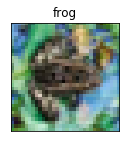

In [5]:
cifar_labels=['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
pl.figure(figsize=(2,2)) 
pl.xticks([]); pl.yticks([])
pl.title(cifar_labels[y_train1[200][0]])
pl.imshow(x_train1[200]);

In [6]:
f=h5py.File(fpath2+'FlowerColorImages.h5','r') 
keys=list(f.keys()); keys
images=np.array(f[keys[0]])/255
labels=np.array(f[keys[1]]).astype('int').reshape(-1,1)
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.2,random_state=1)
del images,labels
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2],
 [cy_train2,cy_valid2,cy_test2]]=\
prepro(x_train2,y_train2,x_test2,y_test2)

,train,valid,test
images,"(168, 128, 128, 3)","(21, 128, 128, 3)","(21, 128, 128, 3)"
labels,"(168, 1)","(21, 1)","(21, 1)"
encoded labels,"(168, 10)","(21, 10)","(21, 10)"


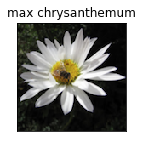

In [7]:
flower_labels=['phlox','rose','calendula','iris',
               'max chrysanthemum','bellflower','viola',
               'rudbeckia laciniata','peony','aquilegia']
pl.figure(figsize=(2,2)) 
pl.xticks([]); pl.yticks([])
pl.title(flower_labels[y_train2[150][0]])
pl.imshow(x_train2[150]);

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Fast Examples</h1>

40960/35363 [==================================] - 0s 0us/step
('crane', 0.1491689)
('lakeside', 0.11947847)
('pirate', 0.072678655)
('missile', 0.052838102)
('wreck', 0.0494856)


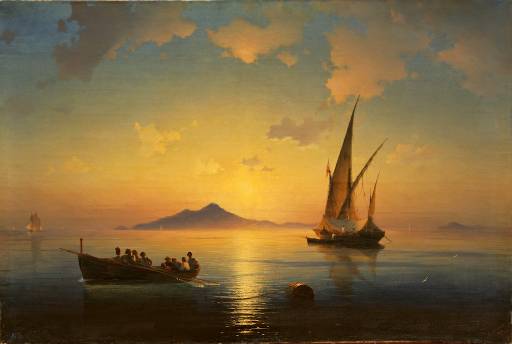

In [8]:
content_image=load_img(fpath+'picture02.png')
x=tf.keras.applications.vgg19\
.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
vgg19=tf.keras.applications\
.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg19(x)
predicted_top5=tf.keras.applications.vgg19\
.decode_predictions(prediction_probabilities.numpy())[0]
[print((class_name,prob)) 
 for (number,class_name,prob) in predicted_top5]
tensor_to_image(content_image)

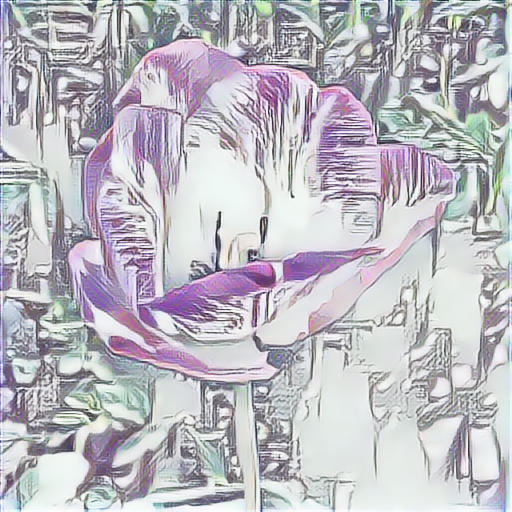

In [9]:
hub_module=th.load(hpath)  
content_image=load_img(fpath+'picture03.png')
style_image=load_img(fpath+'pattern05.png')
stylized_image=hub_module(tf.constant(content_image),
                          tf.constant(style_image))[0]
tensor_to_image(stylized_image)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Keras Models </h1>
MLP

In [10]:
def mlp_model(s):
    model=tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(s,s,3)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
model=mlp_model(32)
model.fit(x_train1,y_train1,epochs=50,batch_size=16,
          validation_data=(x_valid1,y_valid1),
          callbacks=cb(fw1));

Train on 50000 samples, validate on 5000 samples
Epoch 1/50
49872/50000 [============================>.] - ETA: 0s - loss: 1.9336 - accuracy: 0.3295
Epoch 00001: val_loss improved from inf to 2.52811, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.9331 - accuracy: 0.3298 - val_loss: 2.5281 - val_accuracy: 0.3980
Epoch 2/50
49920/50000 [============================>.] - ETA: 0s - loss: 1.7037 - accuracy: 0.3912
Epoch 00002: val_loss improved from 2.52811 to 2.03071, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 13s 269us/sample - loss: 1.7039 - accuracy: 0.3912 - val_loss: 2.0307 - val_accuracy: 0.3856
Epoch 3/50
49984/50000 [============================>.] - ETA: 0s - loss: 1.6485 - accuracy: 0.4146
Epoch 00003: val_loss did not improve from 2.03071
50000/50000 [==============================] - 12s 249us/sample - loss: 1.6485 - accuracy: 0.4146 - val_loss: 2.1564 - val_accuracy:

In [12]:
model.load_weights(fw1)
model.evaluate(x_test1,y_test1)

5000/5000 [==============================] - 0s 75us/sample - loss: 2.2490 - accuracy: 0.3760


[2.24901063785553, 0.376]

In [13]:
model=mlp_model(128)
model.fit(x_train2,y_train2,epochs=50,batch_size=16,
          validation_data=(x_valid2,y_valid2),
          callbacks=cb(fw2))

Train on 168 samples, validate on 21 samples
Epoch 1/50
128/168 [=====================>........] - ETA: 0s - loss: 2.3434 - accuracy: 0.2656    
Epoch 00001: val_loss improved from inf to 8.91122, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 1s 8ms/sample - loss: 2.2466 - accuracy: 0.2976 - val_loss: 8.9112 - val_accuracy: 0.1429
Epoch 2/50
160/168 [===========================>..] - ETA: 0s - loss: 1.3975 - accuracy: 0.5875
Epoch 00002: val_loss improved from 8.91122 to 7.33483, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 0s 2ms/sample - loss: 1.3646 - accuracy: 0.5893 - val_loss: 7.3348 - val_accuracy: 0.1429
Epoch 3/50
144/168 [========================>.....] - ETA: 0s - loss: 0.7732 - accuracy: 0.7569
Epoch 00003: val_loss improved from 7.33483 to 4.41600, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 0s 2ms/sample - loss: 0.7553 - accuracy: 0.7560 - val_loss: 4.41

In [14]:
model.load_weights(fw2)
model.evaluate(x_test2,y_test2)

21/21 [==============================] - 0s 303us/sample - loss: 2.2371 - accuracy: 0.4762


[2.2370758056640625, 0.47619048]

CNN

In [15]:
def cnn_model(s):
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(5,5),padding='same',
                               input_shape=(s,s,3)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(196,(5,5)),
        tf.keras.layers.Activation('relu'),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.GlobalMaxPooling2D(),    
        tf.keras.layers.Dense(512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
model=cnn_model(32)
model.fit(x_train1,cy_train1,epochs=150,batch_size=64,
          validation_data=(x_valid1,cy_valid1),
          callbacks=cb(fw1))

Train on 50000 samples, validate on 5000 samples
Epoch 1/150
49664/50000 [============================>.] - ETA: 0s - loss: 2.4609 - accuracy: 0.2102
Epoch 00001: val_loss improved from inf to 1.92774, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 5s 104us/sample - loss: 2.4582 - accuracy: 0.2103 - val_loss: 1.9277 - val_accuracy: 0.3310
Epoch 2/150
49536/50000 [============================>.] - ETA: 0s - loss: 1.8232 - accuracy: 0.3207
Epoch 00002: val_loss improved from 1.92774 to 1.77361, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 5s 91us/sample - loss: 1.8225 - accuracy: 0.3213 - val_loss: 1.7736 - val_accuracy: 0.3824
Epoch 3/150
49792/50000 [============================>.] - ETA: 0s - loss: 1.6984 - accuracy: 0.3736
Epoch 00003: val_loss improved from 1.77361 to 1.63774, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 4s 89us/sample - loss: 1.6985 - accuracy

In [17]:
model.load_weights(fw1)
model.evaluate(x_test1,cy_test1)

5000/5000 [==============================] - 0s 84us/sample - loss: 0.7379 - accuracy: 0.7516


[0.7378918009281158, 0.7516]

In [18]:
model=cnn_model(128)
model.fit(x_train2,cy_train2,epochs=100,batch_size=64,
          validation_data=(x_valid2,cy_valid2),
          callbacks=cb(fw2))

Train on 168 samples, validate on 21 samples
Epoch 1/100
 64/168 [==========>...................] - ETA: 1s - loss: 2.2917 - accuracy: 0.0938
Epoch 00001: val_loss improved from inf to 2.27453, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 1s 8ms/sample - loss: 2.3103 - accuracy: 0.1071 - val_loss: 2.2745 - val_accuracy: 0.1429
Epoch 2/100
 64/168 [==========>...................] - ETA: 0s - loss: 2.2334 - accuracy: 0.1719
Epoch 00002: val_loss improved from 2.27453 to 2.25767, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 0s 1ms/sample - loss: 2.2424 - accuracy: 0.1607 - val_loss: 2.2577 - val_accuracy: 0.1905
Epoch 3/100
 64/168 [==========>...................] - ETA: 0s - loss: 2.1851 - accuracy: 0.1719
Epoch 00003: val_loss improved from 2.25767 to 2.19573, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 0s 997us/sample - loss: 2.1521 - accuracy: 0.2143 - val_loss: 2.1

In [19]:
model.load_weights(fw2)
model.evaluate(x_test2,cy_test2)

21/21 [==============================] - 0s 439us/sample - loss: 0.7662 - accuracy: 0.8095


[0.7662308812141418, 0.8095238]

RNN

In [20]:
def rnn_model(s,h):
    model=tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(1,s*s*3)),
        tf.keras.layers.LSTM(h,return_sequences=True), 
        tf.keras.layers.LSTM(h,return_sequences=True),
        tf.keras.layers.LSTM(h),         
        tf.keras.layers.Dense(10,activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model

In [21]:
model=rnn_model(32,96)
model.fit(x_train1.reshape(-1,1,32*32*3),cy_train1,
          epochs=50,batch_size=128,
          validation_data=(x_valid1.reshape(-1,1,32*32*3),
                           cy_valid1),
          callbacks=cb(fw1))

Train on 50000 samples, validate on 5000 samples
Epoch 1/50
49920/50000 [============================>.] - ETA: 0s - loss: 1.8050 - accuracy: 0.3453
Epoch 00001: val_loss improved from inf to 1.64959, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 9s 183us/sample - loss: 1.8052 - accuracy: 0.3452 - val_loss: 1.6496 - val_accuracy: 0.4026
Epoch 2/50
49408/50000 [============================>.] - ETA: 0s - loss: 1.6288 - accuracy: 0.4114
Epoch 00002: val_loss improved from 1.64959 to 1.58172, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 4s 84us/sample - loss: 1.6288 - accuracy: 0.4114 - val_loss: 1.5817 - val_accuracy: 0.4380
Epoch 3/50
49536/50000 [============================>.] - ETA: 0s - loss: 1.5616 - accuracy: 0.4386
Epoch 00003: val_loss improved from 1.58172 to 1.54646, saving model to weights.best.cifar.hdf5
50000/50000 [==============================] - 4s 81us/sample - loss: 1.5619 - accuracy: 0

In [22]:
model.load_weights(fw1)
model.evaluate(x_test1.reshape(-1,1,32*32*3),cy_test1)

5000/5000 [==============================] - 1s 133us/sample - loss: 1.4869 - accuracy: 0.4812


[1.4869071582794189, 0.4812]

In [23]:
model=rnn_model(128,256)
model.fit(x_train2.reshape(-1,1,128*128*3),cy_train2,
          epochs=50,batch_size=128,
          validation_data=(x_valid2.reshape(-1,1,128*128*3),
                           cy_valid2),
          callbacks=cb(fw2))

Train on 168 samples, validate on 21 samples
Epoch 1/50
128/168 [=====================>........] - ETA: 1s - loss: 2.3019 - accuracy: 0.0938
Epoch 00001: val_loss improved from inf to 2.28001, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 6s 39ms/sample - loss: 2.2935 - accuracy: 0.1786 - val_loss: 2.2800 - val_accuracy: 0.1905
Epoch 2/50
128/168 [=====================>........] - ETA: 0s - loss: 2.2165 - accuracy: 0.5625
Epoch 00002: val_loss improved from 2.28001 to 2.26359, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 2s 10ms/sample - loss: 2.2177 - accuracy: 0.4940 - val_loss: 2.2636 - val_accuracy: 0.1429
Epoch 3/50
128/168 [=====================>........] - ETA: 0s - loss: 2.1499 - accuracy: 0.6328
Epoch 00003: val_loss improved from 2.26359 to 2.23385, saving model to weights.best.flowers.hdf5
168/168 [==============================] - 11s 64ms/sample - loss: 2.1347 - accuracy: 0.6310 - val_loss: 2.23

In [24]:
model.load_weights(fw2)
model.evaluate(x_test2.reshape(-1,1,128*128*3),cy_test2)

21/21 [==============================] - 0s 674us/sample - loss: 2.0782 - accuracy: 0.2381


[2.0782418251037598, 0.23809524]